## Import Dataset

In [1]:
!pip install opendatasets
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
  

In [2]:
import opendatasets as od
import pandas as pd

# Download Hotels dataset from Kaggle
od.download(
    "https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hnewbold
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews


100%|██████████| 5.14M/5.14M [00:01<00:00, 3.89MB/s]

In [3]:
import pandas as pd
# Read the csv file
file =('/content/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
raw_dataset = pd.read_csv(file)

# Display the contents of the csv file
raw_dataset.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


## Clean and Explore the Dataset

In [4]:
# Check observation counts and datatypes
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
# Check for duplicates
raw_dataset.duplicated().sum()

0

In [6]:
# Make a copy of the dataset
cleaned_dataset = raw_dataset.copy(deep=True)

In [7]:
# Create function to group ratings
def grouper(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

In [8]:
# Create a grouped rating columm
cleaned_dataset['grouped_rating'] = cleaned_dataset['Rating'].apply(grouper)

<ipython-input-9-465ced41d493>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=cleaned_dataset, x='grouped_rating', palette='viridis')


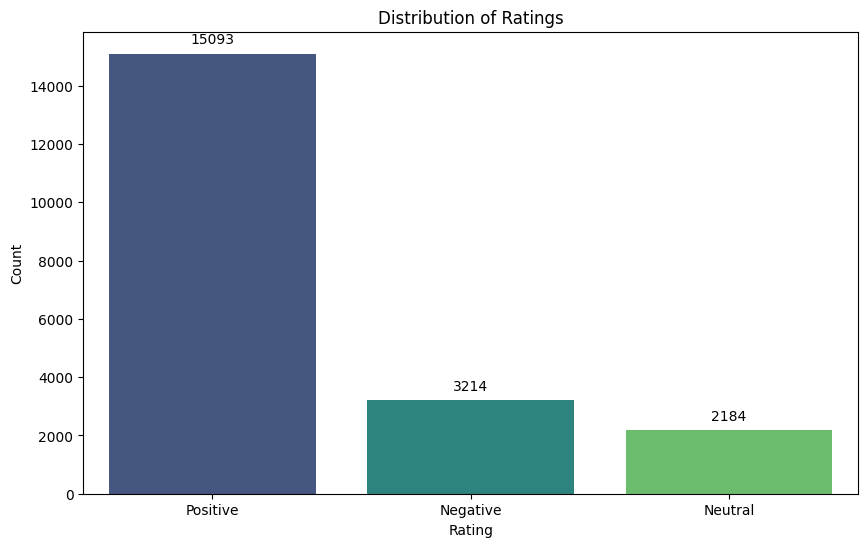

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Show distribution of grouped ratings
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=cleaned_dataset, x='grouped_rating', palette='viridis')

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [10]:
# Take samples of each of the different ratings groups
sampled_negative = cleaned_dataset[cleaned_dataset['grouped_rating'] == 'Positive'].sample(2000, random_state=15)
sampled_neutral = cleaned_dataset[cleaned_dataset['grouped_rating'] == 'Neutral'].sample(2000, random_state=15)
sampled_positive = cleaned_dataset[cleaned_dataset['grouped_rating'] == 'Negative'].sample(2000, random_state=15)

In [11]:
# Combine the sampled instances into a single balanced dataset
cleaned_dataset_balanced_sample = pd.concat([sampled_negative, sampled_neutral, sampled_positive]).reset_index(drop=True)

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### Create functions to clean and lemmatize reviews

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
# Apply function to clean_dataset
cleaned_dataset_balanced_sample['cleaned_review'] = cleaned_dataset_balanced_sample['Review'].apply(clean_text)

In [22]:
# Set display option to not truncate the column output
pd.set_option('display.max_colwidth', None)

# Identify rows where stop words were removed
mask = cleaned_dataset_balanced_sample['Review'].str.contains(r'\b(?:{})\b'.format('|'.join(stop_words)))

# Filter rows where text length is less than or equal to 100 characters
length_mask = cleaned_dataset_balanced_sample['Review'].str.len() <= 100

# Combine both masks
combined_mask = mask & length_mask

# Display rows where stop words were removed and text length is <= 100 characters
filtered_df = cleaned_dataset_balanced_sample[combined_mask][['Review', 'cleaned_review']]

# Display the filtered DataFrame
print(filtered_df)

                                                                                                    Review  \
1279  loved art, comfortable chic hotel huge bed, late checking-in time hinderance excellent experience,     
2010                                          nice odd nice place stay, just buddies seeing paris, good,     
2768       bathroom shower hotel staff good.you sit bathtub order use hand shower, no refrigerator room,     
2793                not bad, not bad hotel needs renovation beach pool good restaurant rooms need touch,     
3224                basic nice, basic hotel clean tidy, did n't think staff friendly honest n't helpful,     
3578                                                       issues n't say 4 star service great pool bar,     
3615                                        big price small room price hype expect sooooo just adequate,     
4201             warning, careful staying place, hotel residence, people place charge day not residence,     
4403      

In [23]:
# Apply lemmatization
cleaned_dataset_balanced_sample['lemmatized_text'] = cleaned_dataset_balanced_sample['cleaned_review'].apply(lemmatize_text)

In [24]:
# Check for sucessful lemmatization
cleaned_dataset_balanced_sample[['cleaned_review','lemmatized_text']].head(3)

,cleaned_review,lemmatized_text
0,sabrina concierge tremendous spent week le littre october concierge staff helpful arranging transportation airport various small things story end left wallet blouse room checked called sabrina airport located items shipped home new jersey leaving wallet potentially disaster intact sabrina nothing short wonderful,sabrina concierge tremendous spent week le littre october concierge staff helpful arranging transportation airport various small thing story end left wallet blouse room checked called sabrina airport located item shipped home new jersey leaving wallet potentially disaster intact sabrina nothing short wonderful
1,nice choice enjoyed staying hotel room mate mario room simple nice clean location wonderful near opera plaza del sol breakfast wonderful staff kind,nice choice enjoyed staying hotel room mate mario room simple nice clean location wonderful near opera plaza del sol breakfast wonderful staff kind
2,great great hotel rooms nice breakfast great service high standardof course free bus airport long parking free book arrangement etcto city center 8 km free rental bike close beautifal forest jogging walking,great great hotel room nice breakfast great service high standardof course free bus airport long parking free book arrangement etcto city center 8 km free rental bike close beautifal forest jogging walking


### Explore Data

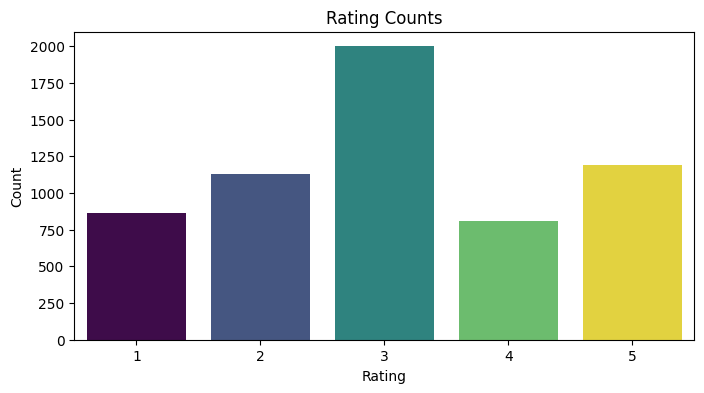

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the rating counts of the balanced dataset
plt.figure(figsize=(8, 4))
sns.countplot(x='Rating', data=cleaned_dataset_balanced_sample, hue = 'Rating', legend=False, palette='viridis')
plt.title('Rating Counts')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


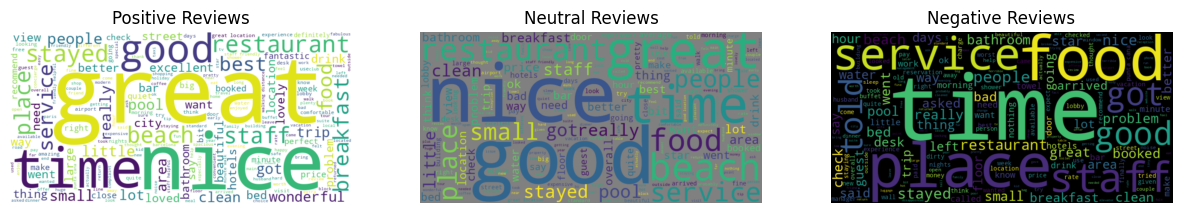

In [27]:
from wordcloud import WordCloud

## Plot word clouds

# Define additional stopwords
additional_stopwords = set(['hotel', 'room','rooms','stay','resort','day','night'])

# Combine with existing stopwords
stopwords = WordCloud().stopwords.union(additional_stopwords)

# Create text for each category using the cleaned_review column
positive_text = ' '.join(cleaned_dataset_balanced_sample[cleaned_dataset_balanced_sample['Rating'].isin([4, 5])]['cleaned_review'])
neutral_text = ' '.join(cleaned_dataset_balanced_sample[cleaned_dataset_balanced_sample['Rating'] == 3]['cleaned_review'])
negative_text = ' '.join(cleaned_dataset_balanced_sample[cleaned_dataset_balanced_sample['Rating'].isin([1, 2])]['cleaned_review'])

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(positive_text)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='grey', stopwords=stopwords).generate(neutral_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', stopwords=stopwords).generate(negative_text)

# Plot the word clouds
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis('off')

plt.show()


## Build Model

In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [29]:
# Function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['lemmatized_text'], truncation=True, padding='max_length', max_length=512)

In [31]:
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
cleaned_dataset_balanced_sample['label'] = cleaned_dataset_balanced_sample['grouped_rating'].map(label_map)

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(cleaned_dataset_balanced_sample[['lemmatized_text', 'label']])
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split the dataset
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

In [36]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
)

# Define the Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.653900,0.560622
2,0.515600,0.568494
3,0.362600,0.676945


TrainOutput(global_step=900, training_loss=0.48618685139550105, metrics={'train_runtime': 1485.9333, 'train_samples_per_second': 16.151, 'train_steps_per_second': 1.009, 'total_flos': 3788901251481600.0, 'train_loss': 0.48618685139550105, 'epoch': 3.0})

## Evaluate Model

In [38]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.5606216192245483,
 'eval_runtime': 36.661,
 'eval_samples_per_second': 32.732,
 'eval_steps_per_second': 2.046,
 'epoch': 3.0}

In [39]:
import numpy as np

# Make predictions on the validation set
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)

              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80       419
     Neutral       0.64      0.57      0.61       382
    Positive       0.77      0.87      0.82       399

    accuracy                           0.75      1200
   macro avg       0.74      0.75      0.74      1200
weighted avg       0.74      0.75      0.74      1200



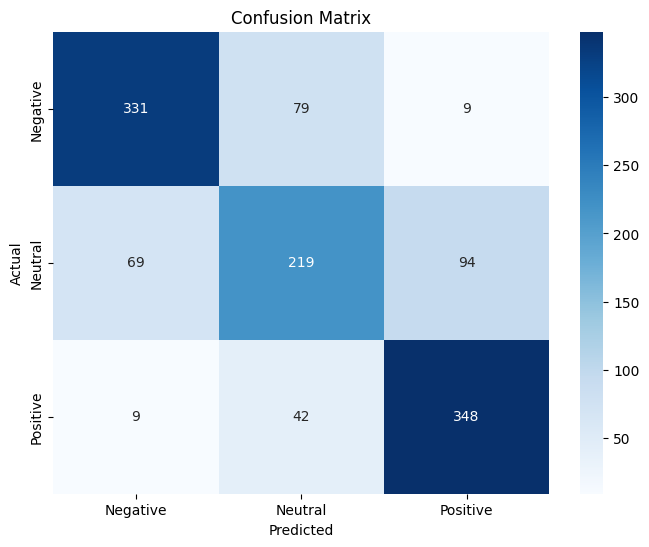

In [40]:
# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_dataset['label'], preds, target_names=['Negative', 'Neutral', 'Positive']))

# Plot confusion matrix
conf_matrix = confusion_matrix(val_dataset['label'], preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()